In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import missingno as ms
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from statannot import add_stat_annotation

In [32]:
data = pd.read_csv('/Users/iseonmi/Desktop/1-1/ME 특론/heart.csv')

In [33]:
import math
import dython
from dython import *
from collections import Counter

In [35]:
# https://github.com/shakedzy/dython/blob/master/dython/nominal.py
    
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from collections import Counter
from dython._private import convert, remove_incomplete_samples, replace_nan_with_value

REPLACE = 'replace'
DROP = 'drop'
DROP_SAMPLES = 'drop_samples'
DROP_FEATURES = 'drop_features'
SKIP = 'skip'
DEFAULT_REPLACE_VALUE = 0.0


def conditional_entropy(x, y, nan_strategy=REPLACE, nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates the conditional entropy of x given y: S(x|y)
    Wikipedia: https://en.wikipedia.org/wiki/Conditional_entropy
    **Returns:** float
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def cramers_v(x, y, nan_strategy=REPLACE, nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
    This is a symmetric coefficient: V(x,y) = V(y,x)
    Original function taken from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def theils_u(x, y, nan_strategy=REPLACE, nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    This is the uncertainty of x given y: value is on the range of [0,1] - where 0 means y provides no information about
    x, and 1 means y provides full information about x.
    This is an asymmetric coefficient: U(x,y) != U(y,x)
    Wikipedia: https://en.wikipedia.org/wiki/Uncertainty_coefficient
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        x, y = replace_nan_with_value(x, y, nan_replace_value)
    elif nan_strategy == DROP:
        x, y = remove_incomplete_samples(x, y)
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


def correlation_ratio(categories, measurements, nan_strategy=REPLACE, nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Calculates the Correlation Ratio (sometimes marked by the greek letter Eta) for categorical-continuous association.
    Answers the question - given a continuous value of a measurement, is it possible to know which category is it
    associated with?
    Value is in the range [0,1], where 0 means a category cannot be determined by a continuous measurement, and 1 means
    a category can be determined with absolute certainty.
    Wikipedia: https://en.wikipedia.org/wiki/Correlation_ratio
    **Returns:** float in the range of [0,1]
    Parameters
    ----------
    categories : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    measurements : list / NumPy ndarray / Pandas Series
        A sequence of continuous measurements
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop' to remove samples with missing values, or 'replace'
        to replace all missing values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'.
    """
    if nan_strategy == REPLACE:
        categories, measurements = replace_nan_with_value(categories, measurements, nan_replace_value)
    elif nan_strategy == DROP:
        categories, measurements = remove_incomplete_samples(categories, measurements)
    categories = convert(categories, 'array')
    measurements = convert(measurements, 'array')
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta


def associations(dataset, nominal_columns=None, mark_columns=False, theil_u=False, plot=True, return_results=False, nan_strategy=REPLACE,
                 nan_replace_value=DEFAULT_REPLACE_VALUE, ax=None, **kwargs):
    """
    Calculate the correlation/strength-of-association of features in data-set with both categorical (eda_tools) and
    continuous features using:
     * Pearson's R for continuous-continuous cases
     * Correlation Ratio for categorical-continuous cases
     * Cramer's V or Theil's U for categorical-categorical cases
    **Returns:** a DataFrame of the correlation/strength-of-association between all features
    **Example:** see `associations_example` under `dython.examples`
    Parameters
    ----------
    dataset : NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed
    nominal_columns : string / list / NumPy ndarray
        Names of columns of the data-set which hold categorical values. Can also be the string 'all' to state that all
        columns are categorical, or None (default) to state none are categorical
    mark_columns : Boolean, default = False
        if True, output's columns' names will have a suffix of '(nom)' or '(con)' based on there type (eda_tools or
        continuous), as provided by nominal_columns
    theil_u : Boolean, default = False
        In the case of categorical-categorical feaures, use Theil's U instead of Cramer's V
    plot : Boolean, default = True
        If True, plot a heat-map of the correlation matrix
    return_results : Boolean, default = False
        If True, the function will return a Pandas DataFrame of the computed associations
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop_samples' to remove samples with missing values,
        'drop_features' to remove features (columns) with missing values, or 'replace' to replace all missing
        values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'
    ax : matplotlib ax, default = None
      Matplotlib Axis on which the heat-map will be plotted
    kwargs : any key-value pairs
        Arguments to be passed to used function and methods
    """
    dataset = convert(dataset, 'dataframe')
    if nan_strategy == REPLACE:
        dataset.fillna(nan_replace_value, inplace=True)
    elif nan_strategy == DROP_SAMPLES:
        dataset.dropna(axis=0, inplace=True)
    elif nan_strategy == DROP_FEATURES:
        dataset.dropna(axis=1, inplace=True)
    columns = dataset.columns
    if nominal_columns is None:
        nominal_columns = list()
    elif nominal_columns == 'all':
        nominal_columns = columns
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0, len(columns)):
        for j in range(i, len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                if columns[i] in nominal_columns:
                    if columns[j] in nominal_columns:
                        if theil_u:
                            corr[columns[j]][columns[i]] = theils_u(dataset[columns[i]], dataset[columns[j]], nan_strategy=SKIP)
                            corr[columns[i]][columns[j]] = theils_u(dataset[columns[j]], dataset[columns[i]], nan_strategy=SKIP)
                        else:
                            cell = cramers_v(dataset[columns[i]], dataset[columns[j]], nan_strategy=SKIP)
                            corr[columns[i]][columns[j]] = cell
                            corr[columns[j]][columns[i]] = cell
                    else:
                        cell = correlation_ratio(dataset[columns[i]], dataset[columns[j]], nan_strategy=SKIP)
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                else:
                    if columns[j] in nominal_columns:
                        cell = correlation_ratio(dataset[columns[j]], dataset[columns[i]], nan_strategy=SKIP)
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
                    else:
                        cell, _ = ss.pearsonr(dataset[columns[i]], dataset[columns[j]])
                        corr[columns[i]][columns[j]] = cell
                        corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    if mark_columns:
        marked_columns = ['{} (nom)'.format(col) if col in nominal_columns else '{} (con)'.format(col) for col in columns]
        corr.columns = marked_columns
        corr.index = marked_columns
    if plot:
        if ax is None:
            # plt.figure(figsize=kwargs.get('figsize', None))
            plt.figure(figsize = (15,10))
        sns.heatmap(corr, annot=kwargs.get('annot', True), fmt=kwargs.get('fmt', '.2f'), ax=ax)
        if ax is None:
            plt.show()
    if return_results:
        return corr


def numerical_encoding(dataset, nominal_columns='all', drop_single_label=False, drop_fact_dict=True, nan_strategy=REPLACE, nan_replace_value=DEFAULT_REPLACE_VALUE):
    """
    Encoding a data-set with mixed data (numerical and categorical) to a numerical-only data-set,
    using the following logic:
    * categorical with only a single value will be marked as zero (or dropped, if requested)
    * categorical with two values will be replaced with the result of Pandas `factorize`
    * categorical with more than two values will be replaced with the result of Pandas `get_dummies`
    * numerical columns will not be modified
    **Returns:** DataFrame or (DataFrame, dict). If `drop_fact_dict` is True, returns the encoded DataFrame.
    else, returns a tuple of the encoded DataFrame and dictionary, where each key is a two-value column, and the
    value is the original labels, as supplied by Pandas `factorize`. Will be empty if no two-value columns are
    present in the data-set
    Parameters
    ----------
    dataset : NumPy ndarray / Pandas DataFrame
        The data-set to encode
    nominal_columns : sequence / string. default = 'all'
        A sequence of the nominal (categorical) columns in the dataset. If string, must be 'all' to state that
        all columns are nominal. If None, nothing happens.
    drop_single_label : Boolean, default = False
        If True, nominal columns with a only a single value will be dropped.
    drop_fact_dict : Boolean, default = True
        If True, the return value will be the encoded DataFrame alone. If False, it will be a tuple of
        the DataFrame and the dictionary of the binary factorization (originating from pd.factorize)
    nan_strategy : string, default = 'replace'
        How to handle missing values: can be either 'drop_samples' to remove samples with missing values,
        'drop_features' to remove features (columns) with missing values, or 'replace' to replace all missing
        values with the nan_replace_value. Missing values are None and np.nan.
    nan_replace_value : any, default = 0.0
        The value used to replace missing values with. Only applicable when nan_strategy is set to 'replace'
    """
    dataset = convert(dataset, 'dataframe')
    if nan_strategy == REPLACE:
        dataset.fillna(nan_replace_value, inplace=True)
    elif nan_strategy == DROP_SAMPLES:
        dataset.dropna(axis=0, inplace=True)
    elif nan_strategy == DROP_FEATURES:
        dataset.dropna(axis=1, inplace=True)
    if nominal_columns is None:
        return dataset
    elif nominal_columns == 'all':
        nominal_columns = dataset.columns
    converted_dataset = pd.DataFrame()
    binary_columns_dict = dict()
    for col in dataset.columns:
        if col not in nominal_columns:
            converted_dataset.loc[:,col] = dataset[col]
        else:
            unique_values = pd.unique(dataset[col])
            if len(unique_values) == 1 and not drop_single_label:
                converted_dataset.loc[:,col] = 0
            elif len(unique_values) == 2:
                converted_dataset.loc[:,col], binary_columns_dict[col] = pd.factorize(dataset[col])
            else:
                dummies = pd.get_dummies(dataset[col],prefix=col)
                converted_dataset = pd.concat([converted_dataset,dummies],axis=1)
    if drop_fact_dict:
        return converted_dataset
    else:
        return converted_dataset, binary_columns_dict

In [43]:
IV = data.iloc[:,0:13]
IV.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

In [37]:
data_cramer = IV.join(data['target'], how='outer')
nominal = ['sex', 'cp', 'fbs', 'restecg', 'exang','slope','ca','thal']

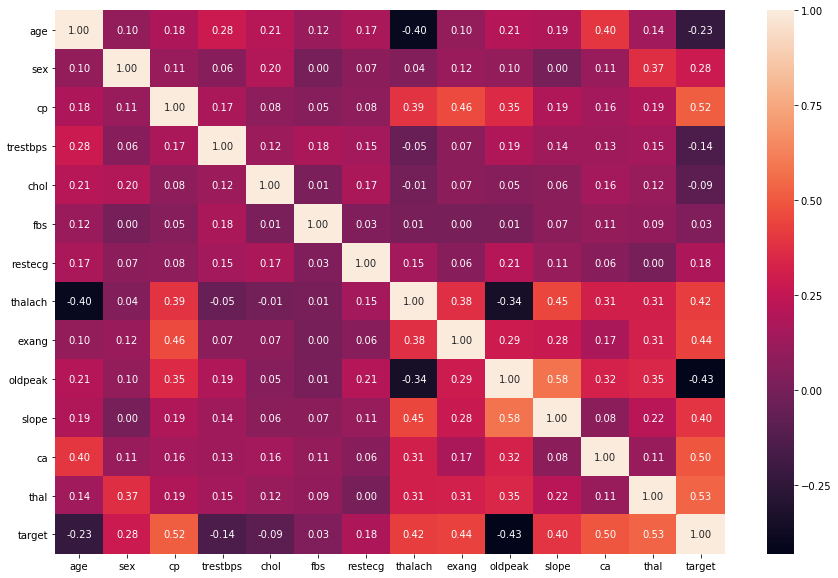

In [39]:
a = associations(data_cramer,nominal_columns=nominal, return_results=True)

In [64]:
for i in data.columns:
    for j in data.columns:
        if a[i][j] >0.2:
            a[i][j] = 1
        else:
            a[i][j] = 0
a[['sex','trestbps','chol','fbs','slope','ca']]

,sex,trestbps,chol,fbs,slope,ca
age,0.0,1.0,1.0,0.0,0.0,1.0
sex,1.0,0.0,0.0,0.0,0.0,0.0
cp,0.0,0.0,0.0,0.0,0.0,0.0
trestbps,0.0,1.0,0.0,0.0,0.0,0.0
chol,0.0,0.0,1.0,0.0,0.0,0.0
fbs,0.0,0.0,0.0,1.0,0.0,0.0
restecg,0.0,0.0,0.0,0.0,0.0,0.0
thalach,0.0,0.0,0.0,0.0,1.0,1.0
exang,0.0,0.0,0.0,0.0,1.0,0.0
oldpeak,0.0,0.0,0.0,0.0,1.0,1.0


In [25]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [27]:
IV_new = data[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'slope', 'ca', 'thal']]
data_cramer = IV_new.join(data['target'], how='outer')
nominal = ['sex', 'cp', 'fbs', 'restecg','slope','ca','thal']

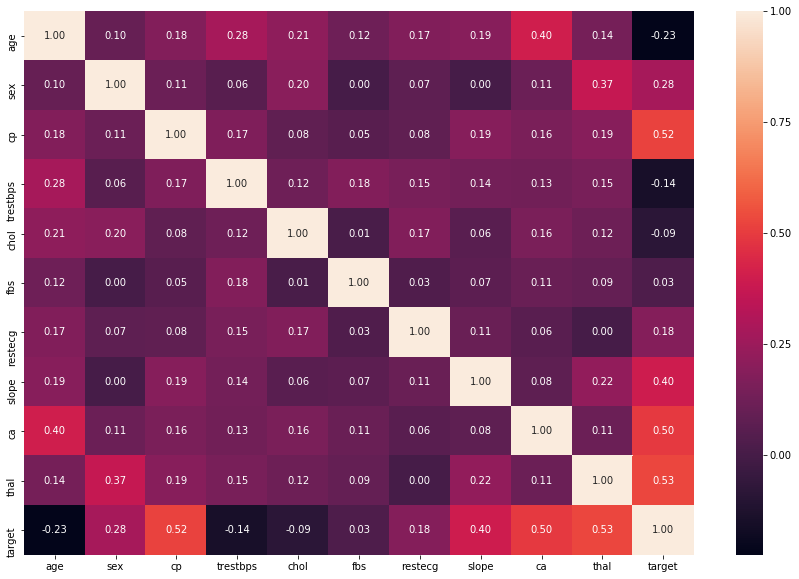

,age,sex,cp,trestbps,chol,fbs,restecg,slope,ca,thal,target
age,1.000000,0.098447,0.181214,0.279351,0.213678,0.121308,0.173845,0.193561,0.401778,0.141359,-0.225439
sex,0.098447,1.000000,0.112353,0.056769,0.197912,0.000000,0.074822,0.000000,0.112691,0.371216,0.280937
cp,0.181214,0.112353,1.000000,0.168682,0.078511,0.053847,0.078058,0.189981,0.156101,0.191089,0.519223
trestbps,0.279351,0.056769,0.168682,1.000000,0.123174,0.177531,0.152450,0.135451,0.131306,0.148630,-0.144931
chol,0.213678,0.197912,0.078511,0.123174,1.000000,0.013294,0.174993,0.061158,0.155742,0.116906,-0.085239
fbs,0.121308,0.000000,0.053847,0.177531,0.013294,1.000000,0.031007,0.067273,0.105215,0.091566,0.028046
restecg,0.173845,0.074822,0.078058,0.152450,0.174993,0.031007,1.000000,0.107320,0.057460,0.000000,0.181878
slope,0.193561,0.000000,0.189981,0.135451,0.061158,0.067273,0.107320,1.000000,0.075967,0.220480,0.395965
ca,0.401778,0.112691,0.156101,0.131306,0.155742,0.105215,0.057460,0.075967,1.000000,0.113529,0.495413
thal,0.141359,0.371216,0.191089,0.148630,0.116906,0.091566,0.000000,0.220480,0.113529,1.000000,0.530594


In [28]:
associations(data_cramer,nominal_columns=nominal, return_results=True)

In [29]:
#thal age 제외
IV_new = data[['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'slope', 'ca']]
data_cramer = IV_new.join(data['target'], how='outer')
nominal = ['sex', 'cp', 'fbs', 'restecg','slope','ca']

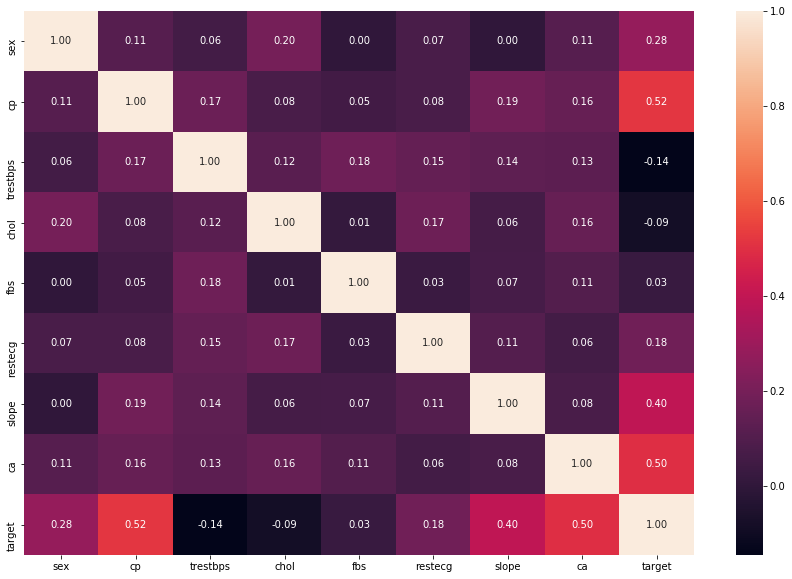

,sex,cp,trestbps,chol,fbs,restecg,slope,ca,target
sex,1.000000,0.112353,0.056769,0.197912,0.000000,0.074822,0.000000,0.112691,0.280937
cp,0.112353,1.000000,0.168682,0.078511,0.053847,0.078058,0.189981,0.156101,0.519223
trestbps,0.056769,0.168682,1.000000,0.123174,0.177531,0.152450,0.135451,0.131306,-0.144931
chol,0.197912,0.078511,0.123174,1.000000,0.013294,0.174993,0.061158,0.155742,-0.085239
fbs,0.000000,0.053847,0.177531,0.013294,1.000000,0.031007,0.067273,0.105215,0.028046
restecg,0.074822,0.078058,0.152450,0.174993,0.031007,1.000000,0.107320,0.057460,0.181878
slope,0.000000,0.189981,0.135451,0.061158,0.067273,0.107320,1.000000,0.075967,0.395965
ca,0.112691,0.156101,0.131306,0.155742,0.105215,0.057460,0.075967,1.000000,0.495413
target,0.280937,0.519223,-0.144931,-0.085239,0.028046,0.181878,0.395965,0.495413,1.000000


In [30]:
associations(data_cramer,nominal_columns=nominal, return_results=True)